# Vanishing/Exploding Gradients Problems

As we discussed in Chapter 10, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step

**Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution**. This is called the vanishing gradients problem. **In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem**, which is mostly encountered in recurrent neural networks. More gener ally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds

A paper titled “Understanding the Difficulty of Training Deep Feedforward Neural Networks” by Xavier Glorot and Yoshua Bengio1 found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time, namely random initialization using a normal distribution with a mean of 0 and a standard deviation of 1. In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks)

Looking at the logistic activation function, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers

<p align='center'>
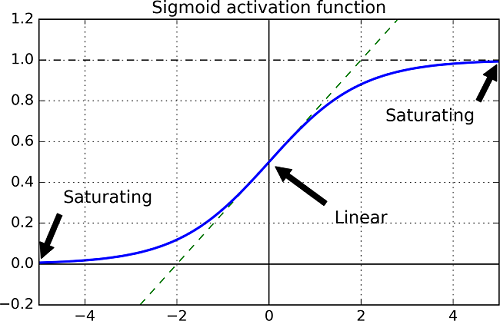
</p>
Figure 11-1. Logistic activation function saturation

## Glorot and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate this problem. We need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients

We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction

It is actually not possible to guarantee both unless the layer has an equal
number of inputs and neurons (these numbers are called the fan-in and fan-out of the
layer), but they proposed a good compromise that has proven to work very well in
practice: **the connection weights of each layer must be initialized randomly as described in Equation below, where**

$$fan_{avg}={(fan_{in} + fan_{out})\over 2}$$

This initialization strategy is called Xavier initialization (after the author’s first name) or Glorot initialization (after his last name)

Equation 11-1. Glorot initialization (when using the logistic activation function)

Normal distribution with mean 0 and variance 
$\sigma^2 = {1 \over fan_{avg}}$ 

Or a uniform distribution between $-r$ and $+r$, with $r = \sqrt{{3 \over fan_{avg}}}$

If you replace $fan_{avg}$ with $fan_{in}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it LeCun initialization. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$, as shown in Table 11-1





Table 11-1. Initialization parameters for each type of activation function

<p align='center'>
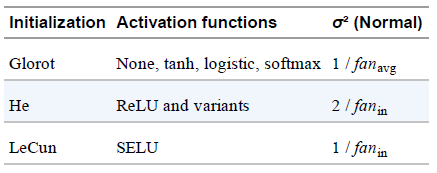
</p>

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting

kernel_initializer="he_uniform" or
kernel_initializer="he_normal" like this:

In [35]:
from tensorflow import keras
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

If you want He initialization with a uniform distribution but based on $fan_{avg}$ rather than $fan_{in}$, you can use the VarianceScaling initializer like this:

In [36]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., 
              mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid',
                   kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function

Other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute)

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, **some neurons effectively “die,” meaning they stop outputting anything other than 0**. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate

A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU

<p align='center'>
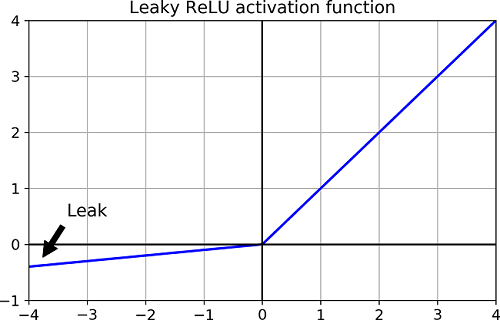
</p>
Figure 11-2. Leaky ReLU: like ReLU, but with a small slope for negative values

Last but not least, a 2015 paper by Djork-Clevert et al. proposed a new activation function called the **exponential linear unit (ELU) that outperformed all the ReLU variants in the authors’ experiments: training time was reduced**, and the neural network performed better on the test set

Figure 11-3 graphs the function, and Equation 11-2 shows its definition

Equation 11-2. ELU activation function

$$ELU_{\alpha}(z) = \begin{cases}  \alpha(exp(z) - 1) & \text{if } z < 0 \\ z & \text{if } z \geq 0 \end{cases}$$

<p align='center'>
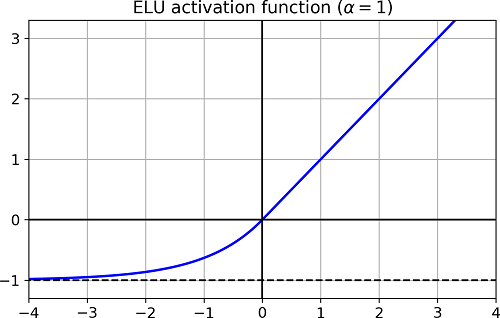
</p>
Figure 11-3. ELU activation function

The ELU activation function looks a lot like the ReLU function, with a few major differences:

* It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem

* The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter

* It has a nonzero gradient for z < 0, which avoids the dead neurons problem

* If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0

The main drawback of the ELU activation function is that it is **slower to compute than the ReLU function and its variants (due to the use of the exponential function)**

Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network


Then, a <a href='https://arxiv.org/abs/1706.02515'>2017 paper</a> by Guter Klambauer et al. introduced the Scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function

The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem

As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen

* The input features must be standardized (mean 0 and standard deviation 1)

* Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting kernel_initializer="lecun_normal"

* The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions

* The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well

To use the leaky ReLU activation function, create a LeakyReLu layer and add it to your model just after the layer you want to apply it to, 
Let's train a neural network on Fashion MNIST using the Leaky ReLU:



In [37]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [38]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, activation='softmax')         
])

In [39]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy']
              )

In [40]:
#history = model.fit(X_train, y_train, epochs=10,
#                    validation_data=(X_valid, y_valid))

For PreLU, replace LeakyRelu(alpha=0.2) with PReLU()

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [42]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy']
              )

In [43]:
#history = model.fit(X_train, y_train, epochs=10,
#                    validation_data=(X_valid, y_valid))

## Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training

In a <a href='https://arxiv.org/abs/1502.03167'>2015 paper</a>, Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) that addresses these problems

The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply **zero centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting**

In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, **you do not need to standardize your training set (e.g., using a StandardScaler)**; the BN layer will do it for you

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the **mean and standard deviation of the input over the current mini-batch** (hence the name “Batch Normalization”

The whole operation is summarized step by step in Equation 11-3

Equation 11-3. Batch Normalization algorithm

$$\mu_B = \frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)} \\ 
{\sigma_B}^2 = \frac{1}{m_B} \sum^{m_B}_{i=1}(x^{(i)} - \mu_B)^2 \\ 
\hat x^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{{\sigma_B}^2 + \epsilon}} \\
z^{(i)} = \gamma \space \otimes \hat x^{(i)} + \beta $$

In this algorithm:

* $\mu_B$ is the vector of input means, evaluted over the whole mini-batch B (it contains one mean per input)

* $\sigma_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input)

* $m_B$ is the number of instances in the mini-batch

* $\hat x^{(i)}$ is the vector of zero-centered and normalized inputs for instance i

* $\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input)

* $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter)

* $\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter

* $\epsilon$ is a tiny number that avoids division by zero (typically $10^{-5}$). This is called a smoothing term

* $z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs

So during training, BN standardizes its inputs, then rescales and offsets them. What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation

Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable

One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer

These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer

To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagaion, and $\mu$ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average

Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3)

Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout)

Batch Normalization does, however, add some complexity to the model. Moreover, there is a runtime penalty: network makes slower predictions due to the extra computations required at each layer

Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset

For example, if the previous layer computes $XW + b$, then the BN layer will compute $\gamma \space \otimes (XW + b - \mu)/ \sigma + \beta $ (ignoring the smoothing term ε in the denominator)

If we define $W' = \gamma \space \otimes W/\sigma$ and $ b' = \gamma \space \otimes (b-\mu)/\sigma + \beta$, the equation simplifies to $XW' + b$. So if we replace the previous layer's weights and biases (W and b) with the updated weights and biases (W' and b'), we can get rid of the BN layer

### Implementing Batch Normalization with Keras

Just add a BatchNormalization layer before or after each hidden layer's activation function, and optionally add a BN layer as well as the first layer in your model

For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [47]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu',
                       kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu',
                       kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In this tiny example with just two hidden layers, it’s unlikely that Batch Normalization will have a very positive impact; but for deeper networks it can make a tremendous difference

Let's display the model summary:

In [48]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 784)               3136      
_________________________________________________________________
dense_30 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
dense_31 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_32 (Dense)             (None, 10)               

As you can see, each BN layer adds four parameters per input: $\gamma , \beta , \mu , \sigma$ (for example, the first BN layer adds 3,136 parameters, which is 4 784)



